In [246]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set(rc={'figure.figsize':(6,8)}) 

import warnings
warnings.simplefilter("ignore")

%matplotlib inline 

from sklearn.preprocessing import LabelEncoder 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS
import re

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Functions

In [247]:
def cleanTxt(txt):
    txt = txt.lower()
    txt = re.sub(r'RT[\s]+', '', txt) #removing RT
    txt = re.sub(r'[^\w\s]','', txt) #remove everything except words and space
    txt = re.sub(r'_','', txt) #how to remove underscore as well
    if 'https' in txt: # removing hyperlinks 
        pos = txt.find('https')
        txt = txt[:pos]
    return txt

In [248]:
wnet = WordNetLemmatizer()

def stopWords(txt): 
    txt_lst = txt.split(" ")
    txt_lst = [word for word in txt_lst if word not in stopwords.words('english')]
    txt_lst = [wnet.lemmatize(word) for word in txt_lst]
    txt_lst = [word for word in txt_lst if word != '']
    txt_lst = [word for word in txt_lst if word != '\r\n\r\n'] # indicates space and indexing
    txt_lst = [word for word in txt_lst if word != 'u0001f449'] # indicates back hand emoji pointing right
    txt_lst = [word for word in txt_lst if word != 'cybersecurity']
    txt_lst = [word for word in txt_lst if word != 'cyber']
    txt_lst = [word for word in txt_lst if word != 'security']
    return " ".join(txt_lst)

In [249]:
#Creating a function that takes in a range of values for K (or how many clusters)
# runs the model and then outputs the inertia value so we can see how well the clusters are grouped 


def evaluate_k_kmeans_inertia(k, vec):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(vec)
    return estimator_kmeans.inertia_

In [311]:
def findCountry(txt):
    if txt is np.nan:
        return 'Unknown'
    x = geolocator.geocode(txt)
    if x is None:
        return 'Unknown'
    loc = x.address.split(',')[-1]
    if loc[0] == " ":
        loc = loc[1:]
    return loc

In [400]:
def cluster_summary(ci, df):
    cluster = df[df.cluster_id==ci]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [433]:
# we can make a function that puts comparisons side by side so its easier for us to see in a data frame 

def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id, df2))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [352]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [353]:
def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

# Cyber Security Tweets | Elyse 

In [251]:
data = pd.read_csv('cybersecurity_tweets.csv')

In [253]:
data = data.drop_duplicates('text')

In [254]:
data.shape

(17656, 90)

In [255]:
len(data.user_id.unique()) # number of unique individuals

7635

In [256]:
df = data[["text", "is_quote", "is_retweet", "retweet_count", "hashtags", "followers_count"]]

In [257]:
text = df[["text"]][:10000] # using subset for now so it will run faster
pd.set_option('display.max_colwidth', -1)
text.head()

,text
0,"Signs, Causes and Solutions for Network Data Breaches | #cybersecurity | #cyberattack https://t.co/oxotVQ4ogO"
1,Battling Chinese Big Tech encroachment in India | #cybersecurity | #cyberattack https://t.co/GFXaut9ZXH
2,Ask Dr. Jeanette® Success On “The Way” Devil On A Choke Chain! It’s Gonna Be Quick! It’s Gonna Be Sure! It’s Gonna Be Final! – Los Angeles Sentinel | Los Angeles Sentinel | #cybersecurity | #cyberattack https://t.co/0yfsRAdUMk
3,Cyber threats to Digital Pakistan | #cybersecurity | #cyberattack https://t.co/Se4ENqeOQT
4,Pakistan Cyber Attack News: Pakistan army claims major cyber attack by Indian intel | World News | #cybersecurity | #cyberattack https://t.co/wsnAO20OiG


# Text Data

## Cleaning Data

In [259]:
text['text'] = text['text'].apply(cleanTxt)
text.head()

,text
0,signs causes and solutions for network data breaches cybersecurity cyberattack
1,battling chinese big tech encroachment in india cybersecurity cyberattack
2,ask dr jeanette success on the way devil on a choke chain its gonna be quick its gonna be sure its gonna be final los angeles sentinel los angeles sentinel cybersecurity cyberattack
3,cyber threats to digital pakistan cybersecurity cyberattack
4,pakistan cyber attack news pakistan army claims major cyber attack by indian intel world news cybersecurity cyberattack


In [262]:
%%time
text['text'] = text['text'].apply(stopWords)
text.head()

CPU times: user 18.8 s, sys: 4.74 s, total: 23.5 s
Wall time: 23.6 s


,text
0,sign cause solution network data breach cyberattack
1,battling chinese big tech encroachment india cyberattack
2,ask dr jeanette success way devil choke chain gonna quick gonna sure gonna final los angeles sentinel los angeles sentinel cyberattack
3,threat digital pakistan cyberattack
4,pakistan attack news pakistan army claim major attack indian intel world news cyberattack


##  Vectorizing Data

Vectorizing using Binary Term Frequency ([link](https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685)). Binary Term Frequency captures presence (1) or absence (0) of term in document. For this part, under TfidfVectorizer, we set binary parameter equal to true so that it can show just presence (1) or absence (0) and norm parameter equal to false.



In [76]:
text_lst = []
for row in text['text']:
    text_lst.append(row)

text_lst[:5] # need to make into a list so the vectorizer will work

['sign cause solution network data breach \xa0cyberattack',
 'battling chinese big tech encroachment india \xa0cyberattack',
 'ask dr jeanette success way devil choke chain gonna quick gonna sure gonna final los angeles sentinel los angeles sentinel \xa0cyberattack',
 'threat digital pakistan \xa0cyberattack',
 'pakistan attack news pakistan army claim major attack indian intel world news \xa0cyberattack']

In [77]:
tv = TfidfVectorizer(
binary = True, norm = None,
use_idf = False, smooth_idf = False,
lowercase = True, stop_words = None,
min_df = 1, max_df = 1.0, max_features = None, ngram_range = (1,1))

In [78]:
text_vec = pd.DataFrame(tv.fit_transform(text_lst).toarray(), columns = tv.get_feature_names())
text_vec.head()

,000,002002,0027,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,013052,013105,013124,013125,...,zscaler,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zyxel,zyz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Making List of Words

In [266]:
cs_words = []

for row in text['text']:
    for word in str(row).split(" "):
        cs_words.append(word)
        
cs_words[:5]

['sign', 'cause', 'solution', 'network', 'data']

In [267]:
len(cs_words)

126356

In [268]:
from nltk.probability import FreqDist
fdist = FreqDist()
for word in cs_words:
    fdist[word]+=1
fdist

FreqDist({'infosec': 976, 'data': 849, 'ransomware': 820, 'attack': 781, '\xa0cyberattack': 690, 'new': 644, 'amp': 591, 'cybersecuritytips': 584, 'ethicalhacking': 580, 'cybersecuritynews': 577, ...})

In [269]:
freq_data = pd.DataFrame.from_dict(fdist.most_common(20))

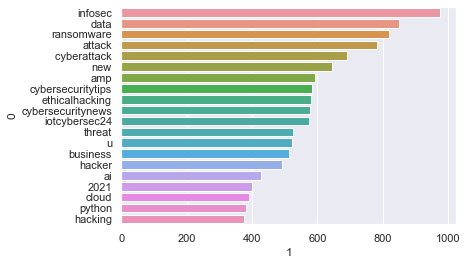

In [270]:
sns.barplot(data = freq_data, x = 1, y = 0);

In [271]:
most_common = []

for key in fdist.most_common(20):
    most_common.append(key[0])
    
#print(most_common)

## Clustering | By Text

### Finding K

In [94]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, text_vec)

running Kmeans with k=1
running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=6
running Kmeans with k=7
running Kmeans with k=8
CPU times: user 12min 17s, sys: 12.3 s, total: 12min 29s
Wall time: 2min 38s


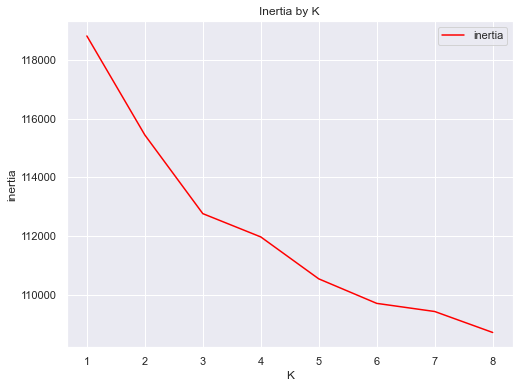

In [96]:
# we can now plot this to see where the inflection point is or where adding more clusters doesnt really add to gaining
# more information from extra clusters

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

### Cluster Analysis

In [97]:
estimator_kmeans = KMeans(random_state=42, n_clusters=7) # making it 7 now to see what happens

estimator_kmeans.fit(text_vec) 

KMeans(n_clusters=7, random_state=42)

In [98]:
text_vec["cluster_id"] = estimator_kmeans.labels_
text_vec.head()

,000,002002,0027,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,013052,013105,013124,013125,...,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zyxel,zyz,cluster_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [99]:
text_clusters = text_vec.groupby('cluster_id').sum()
text_clusters.head()

,000,002002,0027,004002,006,00b328bc1cf5221fc6efb560c6bb764922c31e002179799da67f1f68a503ca41,013052,013105,013124,013125,...,zscaler,zta,ztna,zuckerbergstyle,zum,zumbullaw,zurich,zwatest,zyxel,zyz
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0


In [100]:
text_clusters_20 = text_clusters[['infosec',
 'data',
 'ransomware',
 'attack',
 'cyberattack',
 'new',
 'amp',
 'cybersecuritytips',
 'ethicalhacking',
 'cybersecuritynews',
 'iotcybersec24',
 'threat',
 'business',
 'hacker',
 'ai',
 '2021',
 'cloud',
 'python',
 'hacking']
]

text_clusters_20.head() # only focusing on top 20 post popular words ('u' not in data frame oddly)

,infosec,data,ransomware,attack,cyberattack,new,amp,cybersecuritytips,ethicalhacking,cybersecuritynews,iotcybersec24,threat,business,hacker,ai,2021,cloud,python,hacking
cluster_id,,,,,,,,,,,,,,,,,,,
0,9.0,6.0,2.0,16.0,23.0,6.0,13.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0,0.0,19.0,3.0,2.0,0.0
1,17.0,11.0,17.0,12.0,6.0,17.0,8.0,0.0,0.0,0.0,0.0,7.0,9.0,19.0,9.0,12.0,6.0,2.0,202.0
2,573.0,10.0,0.0,2.0,0.0,3.0,0.0,573.0,573.0,573.0,573.0,0.0,13.0,2.0,3.0,17.0,6.0,32.0,7.0
3,27.0,29.0,71.0,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,8.0,16.0,211.0,6.0,18.0,211.0,0.0
4,326.0,633.0,0.0,0.0,689.0,507.0,411.0,15.0,6.0,6.0,0.0,320.0,377.0,344.0,239.0,357.0,318.0,111.0,133.0


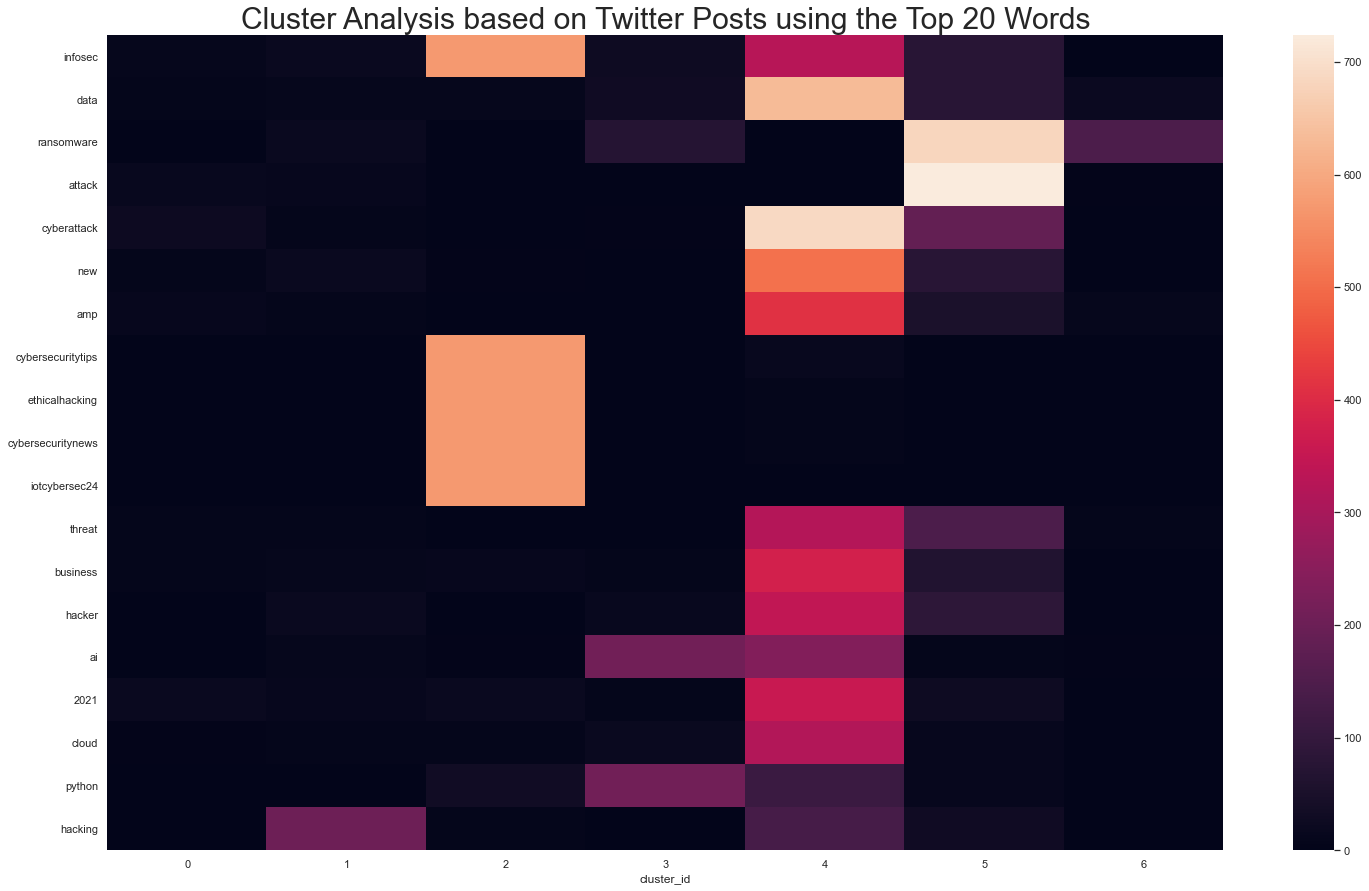

In [101]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(text_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Posts using the Top 20 Words", size = 30);
# Look for rows with a lot of variation to see defining features

## Wordcloud

In [275]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

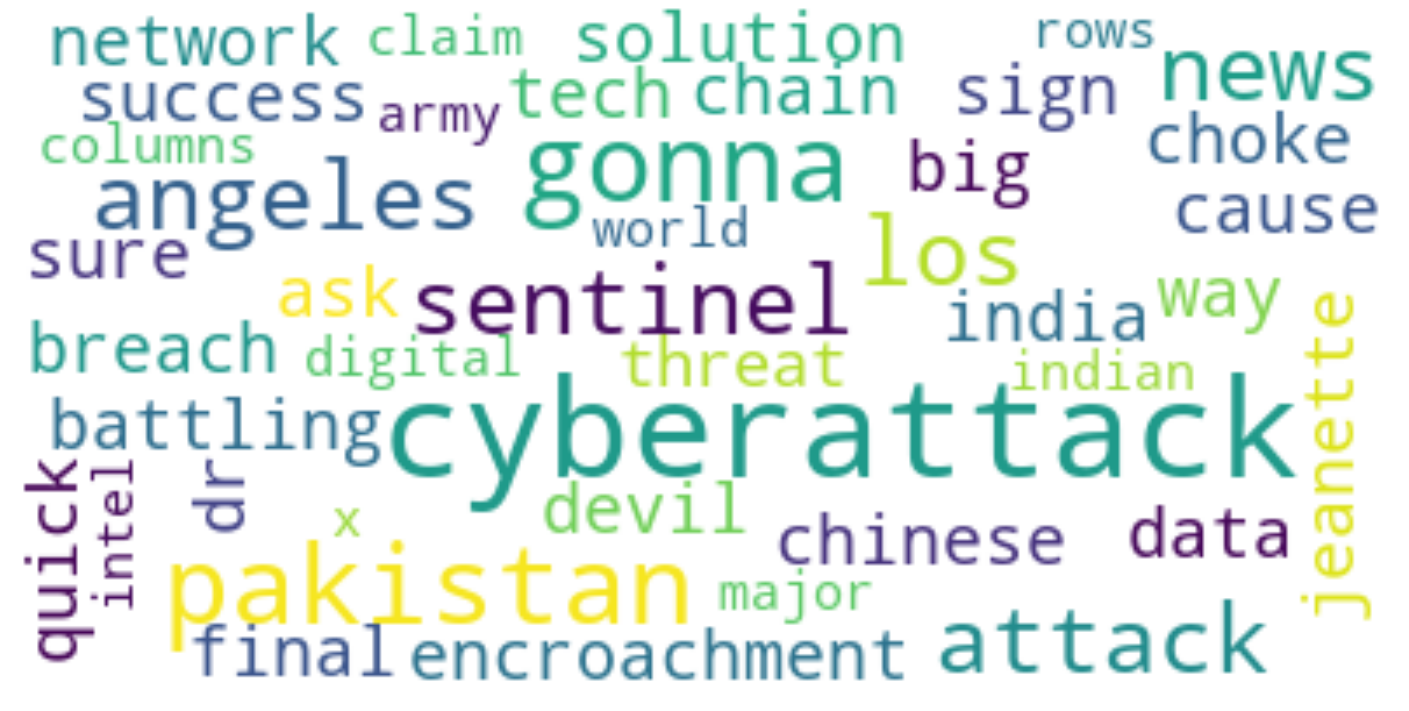

In [276]:
stopwords = set(STOPWORDS)
new_stopwords=stopwords.union(text)
wc = WordCloud(
         background_color="white", max_words=2000, 
         min_font_size =15, max_font_size=40, relative_scaling = 
         0.5, stopwords=new_stopwords,normalize_plurals= True)
import re 
textonly = re.sub(" ", " ",str(text))
wc.generate(textonly)
plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()
# devil is interesting, Intel is possibly the company, 
# Jeanette Manfra is commonly found when searching jeannette
# and cybersecurity
# Microsoft Azure Sentinel is a scalable, cloud-native, security information 
# event management (SIEM) and security orchestration automated response (SOAR) solution. 
# Los Angeles and Pakistan are the only locations, chinese is only nationality

## Sentiment Analysis

In [278]:
sid = SentimentIntensityAnalyzer()
text['scores'] = text['text'].apply(lambda review: sid.polarity_scores(review))
text.head()

,text,scores
0,sign cause solution network data breach cyberattack,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}"
1,battling chinese big tech encroachment india cyberattack,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.2732}"
2,ask dr jeanette success way devil choke chain gonna quick gonna sure gonna final los angeles sentinel los angeles sentinel cyberattack,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'compound': -0.4404}"
3,threat digital pakistan cyberattack,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5267}"
4,pakistan attack news pakistan army claim major attack indian intel world news cyberattack,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compound': -0.7351}"


In [279]:
text['compound']  = text['scores'].apply(lambda score_dict: score_dict['compound'])
text.head()

,text,scores,compound
0,sign cause solution network data breach cyberattack,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}",0.3182
1,battling chinese big tech encroachment india cyberattack,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.2732}",-0.2732
2,ask dr jeanette success way devil choke chain gonna quick gonna sure gonna final los angeles sentinel los angeles sentinel cyberattack,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'compound': -0.4404}",-0.4404
3,threat digital pakistan cyberattack,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5267}",-0.5267
4,pakistan attack news pakistan army claim major attack indian intel world news cyberattack,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compound': -0.7351}",-0.7351


In [280]:
text['comp_score'] = text['compound'].apply(lambda c: 'pos' if c >=0.05 else ('neg' if c <= -0.05 else 'neutral'))
text.head()

,text,scores,compound,comp_score
0,sign cause solution network data breach cyberattack,"{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}",0.3182,pos
1,battling chinese big tech encroachment india cyberattack,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.2732}",-0.2732,neg
2,ask dr jeanette success way devil choke chain gonna quick gonna sure gonna final los angeles sentinel los angeles sentinel cyberattack,"{'neg': 0.256, 'neu': 0.55, 'pos': 0.194, 'compound': -0.4404}",-0.4404,neg
3,threat digital pakistan cyberattack,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5267}",-0.5267,neg
4,pakistan attack news pakistan army claim major attack indian intel world news cyberattack,"{'neg': 0.36, 'neu': 0.64, 'pos': 0.0, 'compound': -0.7351}",-0.7351,neg


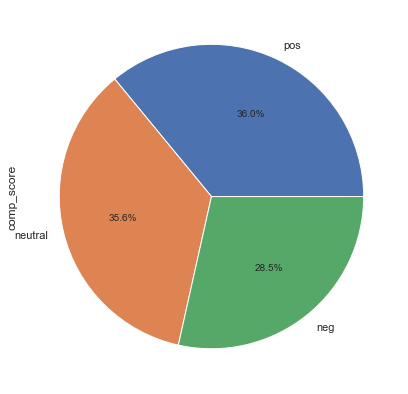

In [287]:
fig, ax = plt.subplots(figsize=(7,7))
comp_score_counts = text.comp_score.value_counts()
comp_score_counts.plot.pie(autopct="%.1f%%");

# Identifying Columns

## Cleaning Data

In [ ]:
ident = data[["verified", "lang", "location", "followers_count", "description", "user_id"]] # can always change later
ident = identifying.drop_duplicates()

In [ ]:
ident.isna().sum()
ident = ident.dropna()
ident.isna().sum()

In [ ]:
ident['description'] = ident['description'].apply(cleanTxt)
ident['description'] = ident['description'].apply(stopWords)
ident.head()

In [ ]:
desc = ident[['description']]
desc.head()

## Vectorizing Data

In [ ]:
desc_lst = []
for row in desc['description']:
    desc_lst.append(row)

desc_lst[:5] # need to make into a list so the vectorizer will work

In [ ]:
desc_vec = pd.DataFrame(tv.fit_transform(desc_lst).toarray(), columns = tv.get_feature_names())
desc_vec.head()

## Making List of Words

In [ ]:
desc_words = []

for row in desc['description']:
    for word in str(row).split(" "):
        desc_words.append(word)
        
desc_words[:5]

In [ ]:
from nltk.probability import FreqDist
fdist_desc = FreqDist()
for word in desc_words:
    fdist_desc[word]+=1
fdist_desc

In [ ]:
freq_data_desc = pd.DataFrame.from_dict(fdist_desc.most_common(20))
sns.barplot(data = freq_data_desc, x = 1, y = 0);

In [ ]:
most_common_desc = []

for key in fdist_desc.most_common(20):
    most_common_desc.append(key[0])
    
most_common_desc

## Clustering | By description

### Finding K

In [ ]:
%%time 
range_k = [i for i in range(1, 9)]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, desc_vec)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

### Cluster Analysis

In [ ]:
estimator_kmeans = KMeans(random_state=42, n_clusters=5) # 5 for now (the elbow curve is janky)

estimator_kmeans.fit(desc_vec) 

In [ ]:
desc_vec["cluster_id"] = estimator_kmeans.labels_
desc_vec.head()

In [ ]:
desc_clusters = desc_vec.groupby('cluster_id').sum()
desc_clusters.head()

In [ ]:
desc_clusters_20 = desc_clusters[['business',
 'technology',
 'service',
 'solution',
 'news',
 'digital',
 'tech',
 'data',
 'cloud',
 'company',
 'help',
 'tweet',
 'information',
 'world',
 'software',
 'management',
 'global',
 'ai',
 'professional']]

desc_clusters_20

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(desc_clusters_20.transpose(), annot=False)
plt.title("Cluster Analysis based on Twitter Description using the Top 20 Words", size = 30);
# Look for rows with a lot of variation to see defining features

## Clustering on Other Columns

In [401]:
df2 = data[["created_at", "is_quote", "retweet_count", "location", "followers_count", "friends_count", "listed_count", "account_created_at", "verified"]][:3000]
df2.head() # remove is_retweet and protected, no variance

,created_at,is_quote,retweet_count,location,followers_count,friends_count,listed_count,account_created_at,verified
0,2021-06-14 17:20:28,False,0,"Atlanta, GA",8524,157,134,2010-01-27 22:48:24,False
1,2021-06-12 08:47:43,False,4,"Atlanta, GA",8524,157,134,2010-01-27 22:48:24,False
2,2021-06-12 16:16:03,False,3,"Atlanta, GA",8524,157,134,2010-01-27 22:48:24,False
3,2021-06-13 10:24:28,False,2,"Atlanta, GA",8524,157,134,2010-01-27 22:48:24,False
4,2021-06-13 12:28:37,False,2,"Atlanta, GA",8524,157,134,2010-01-27 22:48:24,False


In [402]:
#saving only the time
from datetime import datetime, date
df2[["created_at"]] = df2[["created_at"]].apply(pd.to_datetime)

In [403]:
#df2['day_post_created'] = pd.DatetimeIndex(df2["created_at"]).day
#getting only year of when the account was created
# our model is relying a lot on day_post_created. I don't believe it tells us much
# so I am getting rid of it for now and seeing what happens
df2['year_account_created'] = pd.DatetimeIndex(df2["account_created_at"]).year
df2 = df2.drop(["created_at", "account_created_at"], axis=1)
df2['year_account_created'] = df2["year_account_created"].astype("category")
df2.head()

,is_quote,retweet_count,location,followers_count,friends_count,listed_count,verified,year_account_created
0,False,0,"Atlanta, GA",8524,157,134,False,2010
1,False,4,"Atlanta, GA",8524,157,134,False,2010
2,False,3,"Atlanta, GA",8524,157,134,False,2010
3,False,2,"Atlanta, GA",8524,157,134,False,2010
4,False,2,"Atlanta, GA",8524,157,134,False,2010


In [404]:
%%time
df2['country'] = df2['location'].apply(findCountry)
df2.head() # finding country for location (takes 8 minutes for 1000 rows, 18 mins for 3000)

CPU times: user 6.59 s, sys: 713 ms, total: 7.3 s
Wall time: 18min 55s


,is_quote,retweet_count,location,followers_count,friends_count,listed_count,verified,year_account_created,country
0,False,0,"Atlanta, GA",8524,157,134,False,2010,United States
1,False,4,"Atlanta, GA",8524,157,134,False,2010,United States
2,False,3,"Atlanta, GA",8524,157,134,False,2010,United States
3,False,2,"Atlanta, GA",8524,157,134,False,2010,United States
4,False,2,"Atlanta, GA",8524,157,134,False,2010,United States


In [408]:
df2 = df2.drop('location', axis = 1)

In [409]:
numerical_data = df2.select_dtypes(np.number)
categorical_data = df2.drop(numerical_data, axis = 1)

### Processing Data

In [410]:
from sklearn.preprocessing import MinMaxScaler

numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
    numerical_data_normalized,
    columns=numerical_data.columns) 

numerical_data_normalized.head()

,retweet_count,followers_count,friends_count,listed_count
0,0.000000,0.059333,0.004656,0.045843
1,0.048780,0.059333,0.004656,0.045843
2,0.036585,0.059333,0.004656,0.045843
3,0.024390,0.059333,0.004656,0.045843
4,0.024390,0.059333,0.004656,0.045843


In [411]:
categorical_data_codified = pd.get_dummies(
                                    categorical_data, 
                                    drop_first=True,
                                    dtype="int64"
).reset_index()
categorical_data_codified.head()

,index,is_quote,verified,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,...,country_Schweiz/Suisse/Svizzera/Svizra,country_Singapore,country_South Africa,country_The Bahamas,country_United Kingdom,country_United States,country_Unknown,country_Éire / Ireland,country_الإمارات العربية المتحدة,country_پاکستان
0,0,False,False,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,False,False,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,False,False,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,False,False,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,False,False,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [412]:
categorical_data_codified = categorical_data_codified.drop('index', axis = 1) 

In [413]:
df2_processed = pd.concat([
                            numerical_data_normalized,
                            categorical_data_codified
                        ], axis=1
).reset_index()

In [414]:
df2_processed = df2_processed.drop('index', axis = 1)

In [415]:
df2_processed.head()

,retweet_count,followers_count,friends_count,listed_count,is_quote,verified,year_account_created_2009,year_account_created_2010,year_account_created_2011,year_account_created_2012,...,country_Schweiz/Suisse/Svizzera/Svizra,country_Singapore,country_South Africa,country_The Bahamas,country_United Kingdom,country_United States,country_Unknown,country_Éire / Ireland,country_الإمارات العربية المتحدة,country_پاکستان
0,0.000000,0.059333,0.004656,0.045843,False,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.048780,0.059333,0.004656,0.045843,False,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.036585,0.059333,0.004656,0.045843,False,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.024390,0.059333,0.004656,0.045843,False,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.024390,0.059333,0.004656,0.045843,False,False,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Finding K

In [416]:
%%time 
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k, df2_processed)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30
CPU times: user 6.79 s, sys: 336 ms, total: 7.12 s
Wall time: 1.01 s


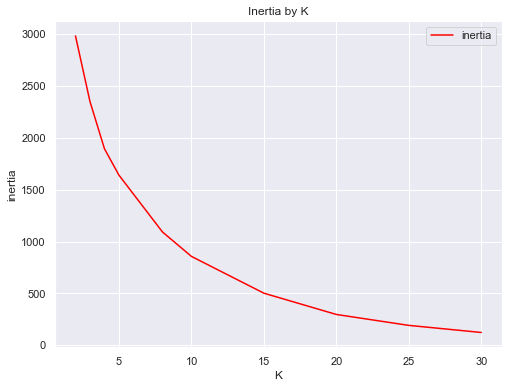

In [417]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend();

### Cluster Analysis

In [418]:
estimator_kmeans = KMeans(random_state=42, n_clusters=10) # 5 for now (the elbow curve is janky)

estimator_kmeans.fit(df2_processed)

KMeans(n_clusters=10, random_state=42)

In [419]:
df2["cluster_id"] = estimator_kmeans.labels_
df2.head()

,is_quote,retweet_count,followers_count,friends_count,listed_count,verified,year_account_created,country,cluster_id
0,False,0,8524,157,134,False,2010,United States,3
1,False,4,8524,157,134,False,2010,United States,3
2,False,3,8524,157,134,False,2010,United States,3
3,False,2,8524,157,134,False,2010,United States,3
4,False,2,8524,157,134,False,2010,United States,3


In [420]:
df2.cluster_id.value_counts()

3    971
2    581
4    327
7    290
1    239
0    230
6    149
5    92 
8    76 
9    45 
Name: cluster_id, dtype: int64

In [422]:
cluster_summary(1, df2)

{'is_quote': 0.0,
 'verified': 0.0,
 'year_account_created': 2010,
 'country': 'Unknown',
 'retweet_count': 1.5355648535564854,
 'followers_count': 9702.167364016736,
 'friends_count': 261.1799163179916,
 'listed_count': 869.3849372384938,
 'cluster_id': 1.0}

In [434]:
cluster_comparison(0,1,2,3,4,5,6,7,8,9)

cluster_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
is_quote,0.021739,0.0,0.0,0.0,0.0,0.108696,0.0,0.113793,0.0,0.0
verified,0.0,0.0,0.0,0.0,0.0,0.0,0.087248,0.006897,0.0,0.0
year_account_created,2017,2010,2017,2010,2020,2011,2009,2018,2014,2009
country,Unknown,Unknown,United States,United States,Unknown,United States,Canada,United States,Éire / Ireland,Singapore
retweet_count,2.386957,1.535565,1.567986,0.897013,7.654434,19.445652,2.563758,2.348276,2.157895,2.644444
followers_count,2172.847826,9702.167364,4850.581756,7537.891864,780.544343,49654.097826,5110.322148,4217.575862,32251.644737,143664.0
friends_count,814.082609,261.179916,4520.425129,666.102987,495.993884,8170.641304,431.979866,1893.1,12997.526316,15276.0
listed_count,231.978261,869.384937,46.848537,129.072091,11.95107,1098.586957,130.865772,132.910345,1619.907895,2923.0


In [435]:
cluster_results = kmeans_cluster(df2_processed, 5)
cluster_summary2 = graph_summary_clustering(cluster_results)

In [437]:
#cluster_summary2 = cluster_summary2.drop('cluster_id', axis = 1)
cluster_summary2

,country_Canada,country_Colombia,country_Deutschland,country_France,country_India,country_Schweiz/Suisse/Svizzera/Svizra,country_Singapore,country_South Africa,country_The Bahamas,country_United Kingdom,...,year_account_created_2012,year_account_created_2013,year_account_created_2014,year_account_created_2015,year_account_created_2016,year_account_created_2017,year_account_created_2018,year_account_created_2019,year_account_created_2020,year_account_created_2021
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.286730,0.00237,0.007109,0.056872,0.049763,0.056872,0.106635,0.004739,0.000000,0.071090,...,0.028436,0.000000,0.180095,0.061611,0.002370,0.000000,0.026066,0.061611,0.000000,0.000000
1,0.003521,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007042,0.147887,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.052224,0.000000,0.000000,0.000000,0.000000,0.000000,0.003868,...,0.029014,0.000000,0.034816,0.079304,0.003868,0.201161,0.001934,0.000000,0.632495,0.001934
4,0.000000,0.00000,0.000000,0.000000,0.001176,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009412,0.021176,0.011765,0.020000,0.048235,0.683529,0.047059,0.000000,0.012941,0.001176


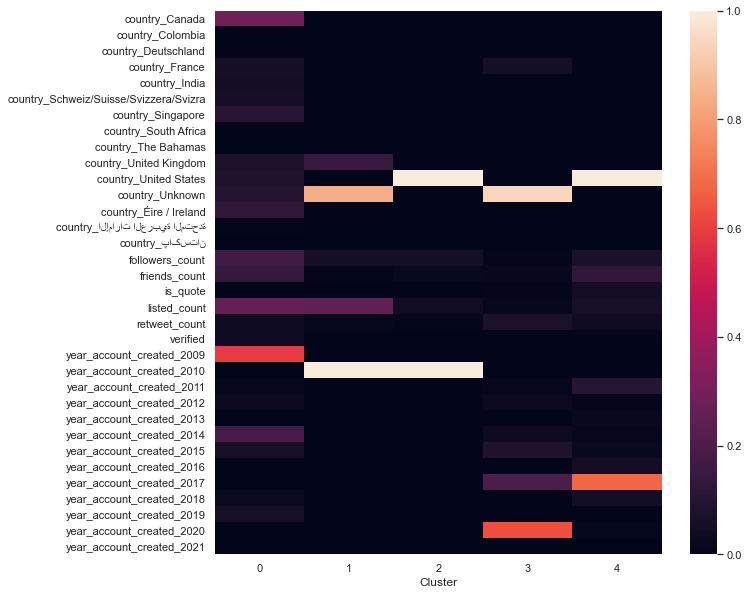

In [438]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary2.transpose(), annot=False);